In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [228]:
# Data - helper functions

def shuffle_data(data): 
    
    # shuffle data
    data = np.array(data)
    np.random.shuffle(data)
    
    return data

def process_data(file_path, train_val_split):
    
    # reads the file, shuffles the data randomly, splits into train 
    # and cross validation sets -> prints corresponding vector dimensions and returns X_train
    # y_train, X_val and y_val
    
    df_train = pd.read_csv(file_path)
    df_train = shuffle_data(df_train)

    train_size = round(df_train.shape[0] * train_val_split)
    data_train = df_train[:train_size,:].T
    data_val = df_train[train_size:,:].T
    print(f'data_train shape: {data_train.shape}')



    X_train = data_train[1:]
    y_train = data_train[0]
    X_val = data_val[1:]

    y_val = data_val[0]
    print(f'X_train shape:{X_train.shape}, \nY_train shape: {y_train.shape}')
    print(f'X_val shape:{X_val.shape}, \nY_val shape: {y_val.shape}')
    print('Data loading complete!')
    return X_train, y_train, X_val, y_val

def normalise_pixels(data):
    
    # divide each pixel by 255 to reduce value between 0 and 1 for a better ANN fit
    return data / 255. 

def visualize_data(X_train,labels,START_IDX,END_IDX):
    IMG_SIZE = 28
    plt.figure(figsize=(5,5))
    for index in range(START_IDX,END_IDX):
        plt.subplot(4,4,1+index)
        plt.imshow(X_train[:,index].reshape(28,28), cmap = plt.cm.binary)
        plt.axis('off')
        plt.title(f'Label: {labels[index]}')
        plt.tight_layout()

def visualize_predicted_data(X_train,labels,START_IDX,END_IDX):
    IMG_SIZE = 28
    plt.figure(figsize=(5,5))
    for index in range(START_IDX,END_IDX):
        plt.subplot(4,4,1+index)
        plt.imshow(X_train[:,index].reshape(28,28), cmap = plt.cm.binary)
        plt.axis('off')
        plt.title(f'prediction: {labels[index]}')
        plt.tight_layout()

In [164]:
# Neural Network - helper functions

def init_params(layer_dims): 
    # initialise the weights and biases based on layers and return them 
    # as a dictionary
    params = {}
    for layer in range(1, len(layer_dims)): 
        params['W'+str(layer)] = np.random.randn(layer_dims[layer], layer_dims[layer-1]) * np.sqrt(1./layer_dims[layer])
        params['b'+str(layer)] = np.random.randn(layer_dims[layer],1) * np.sqrt(1./layer_dims[layer])
        
    return params

def relu(Z): 
    # compute RelU activation function
    return np.maximum(Z,0)

def softmax(Z):
    # compute softmax activation for output layer
    return np.exp(Z) / sum(np.exp(Z))

def relu_derivative(Z): 
    # compute derivative of ReLU 
    return Z>0

def derivative_softmax(Z): 
    
    # compute derivative of softmax
    return np.exp(Z) / sum(np.exp(Z)) * (1. - np.exp(Z) / sum(np.exp(Z)))

def one_hot_encoder(labels):

    Y_hot = np.zeros((labels.shape[0], labels.max()+1))
    Y_hot[np.arange(labels.shape[0]), labels] = 1
    Y_hot = Y_hot.T
    
    return Y_hot

def forward_propagation(X, params):
    # forward prop for neural network -> ReLU for L-1 layers, softmax for output layer
    
    
    # get number of layers from params, //2 since params return W,b for each layer
    layers = len(params) // 2 
    
    activations = {}
    activations['A0'] = X
    
    # input layer to layer L-1 (ReLU)
    
    for layer in range(1, layers): 
        activations['Z'+str(layer)] = np.dot(params['W'+str(layer)], activations['A'+str(layer-1)]) + params['b'+str(layer)]
        activations['A'+str(layer)] = relu(activations['Z'+str(layer)])
        
    # layer L -> softmax activation
    
    activations['Z'+str(layers)] = np.dot(params['W'+str(layers)], activations['A'+str(layers-1)]) + params['b'+str(layers)]
    activations['A'+str(layers)] = softmax(activations['Z'+str(layers)])
    
    return activations


def back_propagation(activations, params, Y):
  
    L = len(params) // 2  
    one_hot_Y = one_hot_encoder(Y)  
    m = one_hot_Y.shape[1]
  
    derivatives = {}
    grads = {}
  
    #  for layer L
    derivatives['dZ'+str(L)] = (activations['A'+str(L)] - one_hot_Y)
    grads['dW'+str(L)] = 1 / m * np.dot(derivatives['dZ'+str(L)], activations['A'+str(L-1)].T)
    grads['db'+str(L)] = 1 / m * np.sum(derivatives['dZ'+str(L)])
   
    # for layers L-1 to 1
    for l in reversed(range(1, L)):
        derivatives['dZ'+str(l)] = np.dot(params['W'+str(l+1)].T, derivatives['dZ'+str(l+1)]) * relu_derivative(activations['Z'+str(l)])
        grads['dW'+str(l)] = 1 / m * np.dot(derivatives['dZ'+str(l)], activations['A'+str(l-1)].T)
        grads['db'+str(l)] = 1 / m * np.sum(derivatives['dZ'+str(l)], axis=1, keepdims=True)
  
    return grads

def update_params(params, grads, alpha):
    layers = len(params) // 2
    
    updated_params = {}
    for layer in range(1, layers+1):
        updated_params['W'+str(layer)] = params['W'+str(layer)] - alpha*grads['dW'+str(layer)]
        updated_params['b'+str(layer)] = params['b'+str(layer)] - alpha*grads['db'+str(layer)]
    
    return updated_params

def cross_entropy(Y_one_hot, Y_hat, epsilon=1e-12):
    
    # clip predictions to avoid values of 0 and 1
    Y_hat = np.clip(Y_hat, epsilon, 1.-epsilon)
    
    # sum on the columns of Y_hat * np.log(Y), then take the mean 
    # between the m samples
    cross_entropy_loss = -np.mean(np.sum(Y_one_hot * np.log(Y_hat), axis=0))
    return cross_entropy_loss

def predictions(data): 
    # return max index by column
    return np.argmax(data, axis=0)

def get_accuracy(y_pred, y):
    
    return np.sum(y_pred == y) / y.size

In [226]:
# gradient descent optimizer - helper function

def gradient_descent(X, Y, layers_size, iterations, learning_rate): 
    
    params = init_params(layers_size)
    
    layers = len(params)//2
    accuracies = []
    losses = []
    
    for iteration in range(1, iterations+1):
        activations = forward_propagation(X, params)
        
        Y_pred = predictions(activations['A'+str(layers)])
        accuracy = get_accuracy(Y_pred, Y)
        accuracies.append(accuracy)
        
        loss = cross_entropy(one_hot_encoder(Y), activations['A'+str(layers)])
        losses.append(loss)
        
        grads = back_propagation(activations, params, Y)
        params = update_params(params, grads, learning_rate)
        
        if iteration % 10 == 0:
            print(f'accuracy at iteration {iteration}: {accuracy}\nmodel loss: {loss}\n')
    
    plt.plot(range(1, iterations+1), accuracies, '-', color=sns.color_palette('deep')[0], linewidth=2, label='Training Accuracy')
    plt.plot(range(1, iterations+1), losses, ':', color=sns.color_palette('deep')[2], linewidth=2, label='Training Loss')
    plt.title("Network's Architecture: {}".format(layers_size))
    plt.legend(loc='upper right')
    plt.ylabel('loss/accuracy')
    plt.xlabel('Iterations')
    
    return params


def test_accuracy(X_val, y_val, params):
    
    layers = len(params) // 2
    start_index = 0
    end_index = 16
    
    
    activations = forward_propagation(X_val, trained_params)
    y_predictions = predictions(activations['A'+str(layers)])
    
    
    visualize_predicted_data(X_val, y_predictions, start_index, end_index)
    accuracy = get_accuracy(y_predictions, y_val)
    
    return accuracy

data_train shape: (785, 33600)
X_train shape:(784, 33600), 
Y_train shape: (33600,)
X_val shape:(784, 8400), 
Y_val shape: (8400,)
Data loading complete!


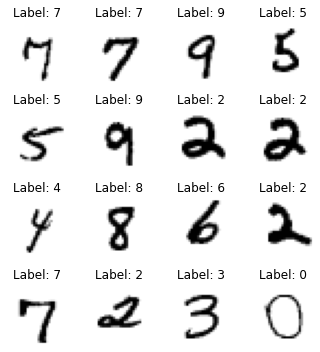

In [222]:
# Load, process and visualize the data - MNIST

X_train, y_train, X_val, y_val = process_data('train.csv', 0.8)
visualize_data(X_train,y_train,START_IDX=0,END_IDX=16)

# normalize training and val sets
X_train = normalise_pixels(X_train)
X_val = normalise_pixels(X_val)


In [217]:
# set network and optimizer parameters  

layer_architecture = [[784, 256, 128, 64, 10], 
                      [784, 128, 32, 10],
                      [784, 128, 10],
                      [784, 32, 10]]
iterations = 150
learning_rate = 0.1

accuracy at iteration 10: 0.6030952380952381
model loss: 1.3988644186360324

accuracy at iteration 20: 0.8092559523809524
model loss: 0.7092784421913754

accuracy at iteration 30: 0.8229464285714285
model loss: 0.5637328257016722

accuracy at iteration 40: 0.8393154761904762
model loss: 0.5018064898724965

accuracy at iteration 50: 0.880327380952381
model loss: 0.4204246290303411

accuracy at iteration 60: 0.8905357142857143
model loss: 0.3814533769626771

accuracy at iteration 70: 0.8964285714285715
model loss: 0.361441076801827

accuracy at iteration 80: 0.9105654761904762
model loss: 0.31255899708401647

accuracy at iteration 90: 0.9149702380952381
model loss: 0.2945918960297851

accuracy at iteration 100: 0.9180952380952381
model loss: 0.2813957478826925

accuracy at iteration 110: 0.9204464285714286
model loss: 0.27288807910431656

accuracy at iteration 120: 0.9205952380952381
model loss: 0.27352798798341044

accuracy at iteration 130: 0.9226488095238096
model loss: 0.266675335667

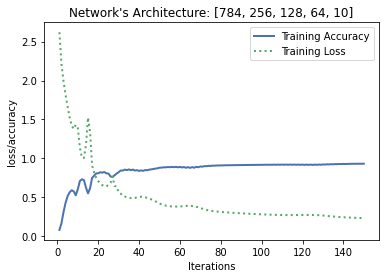

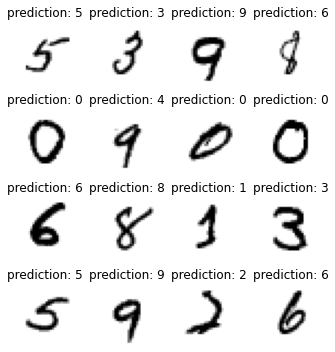

In [229]:
trained_params = gradient_descent(X_train, y_train, layer_architecture[0], iterations, learning_rate)
test_acc = test_accuracy(X_val, y_val, trained_params)
print(f'model test accuracy: {test_acc}')

accuracy at iteration 10: 0.6161607142857143
model loss: 1.367734967751573

accuracy at iteration 20: 0.7555654761904762
model loss: 0.8805563973632872

accuracy at iteration 30: 0.8070833333333334
model loss: 0.6826541770367002

accuracy at iteration 40: 0.835
model loss: 0.5788258305013602

accuracy at iteration 50: 0.8527976190476191
model loss: 0.5140923592897017

accuracy at iteration 60: 0.8655654761904762
model loss: 0.4697329158943909

accuracy at iteration 70: 0.8744940476190476
model loss: 0.43731407634479824

accuracy at iteration 80: 0.8819642857142858
model loss: 0.41249320395019246

accuracy at iteration 90: 0.8874107142857143
model loss: 0.3927513378082351

accuracy at iteration 100: 0.8916666666666667
model loss: 0.37646350644310905

accuracy at iteration 110: 0.895922619047619
model loss: 0.3626562794067305

accuracy at iteration 120: 0.899077380952381
model loss: 0.3507016272502277

accuracy at iteration 130: 0.9023214285714286
model loss: 0.3401880804451271

accuracy

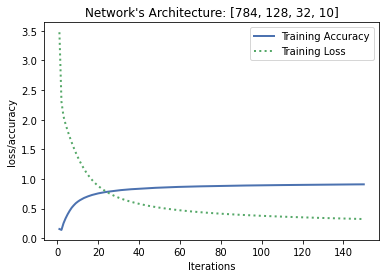

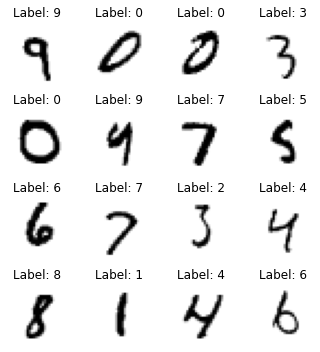

In [219]:
trained_params = gradient_descent(X_train, y_train, layer_architecture[1], iterations, learning_rate)
test_acc = test_accuracy(X_val, y_val, trained_params)
print(f'model test accuracy: {test_acc}')

accuracy at iteration 10: 0.6779761904761905
model loss: 1.0204783394450991

accuracy at iteration 20: 0.790327380952381
model loss: 0.7066264684220309

accuracy at iteration 30: 0.8302083333333333
model loss: 0.5840238787098931

accuracy at iteration 40: 0.8495833333333334
model loss: 0.5157124635325538

accuracy at iteration 50: 0.8629166666666667
model loss: 0.4711341211358621

accuracy at iteration 60: 0.8724107142857143
model loss: 0.4391321617303457

accuracy at iteration 70: 0.8795535714285714
model loss: 0.41461539780557344

accuracy at iteration 80: 0.8860416666666666
model loss: 0.39493504979103305

accuracy at iteration 90: 0.8910119047619047
model loss: 0.3786688365770726

accuracy at iteration 100: 0.8946428571428572
model loss: 0.36487244048459294

accuracy at iteration 110: 0.8972916666666667
model loss: 0.35293217056157866

accuracy at iteration 120: 0.8996726190476191
model loss: 0.3424602423113896

accuracy at iteration 130: 0.9024702380952381
model loss: 0.3331569598

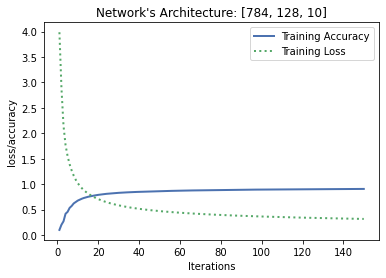

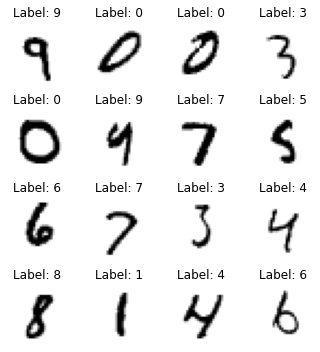

In [220]:
trained_params = gradient_descent(X_train, y_train, layer_architecture[2], iterations, learning_rate)
test_acc = test_accuracy(X_val, y_val, trained_params)
print(f'model test accuracy: {test_acc}')

accuracy at iteration 10: 0.37157738095238096
model loss: 1.8674838871533883

accuracy at iteration 20: 0.549375
model loss: 1.4288434483334045

accuracy at iteration 30: 0.6402678571428572
model loss: 1.163265591874862

accuracy at iteration 40: 0.6919345238095238
model loss: 0.9927961202278216

accuracy at iteration 50: 0.7271726190476191
model loss: 0.8783753528219758

accuracy at iteration 60: 0.7505654761904762
model loss: 0.7975243612330127

accuracy at iteration 70: 0.7697916666666667
model loss: 0.7371878575803795

accuracy at iteration 80: 0.7834523809523809
model loss: 0.6901598181633781

accuracy at iteration 90: 0.7948809523809524
model loss: 0.6523226971607667

accuracy at iteration 100: 0.8044345238095238
model loss: 0.6210179672793484

accuracy at iteration 110: 0.8135119047619047
model loss: 0.5945719009144006

accuracy at iteration 120: 0.8211309523809524
model loss: 0.5718600702719024

accuracy at iteration 130: 0.8279166666666666
model loss: 0.5521484709147142

accur

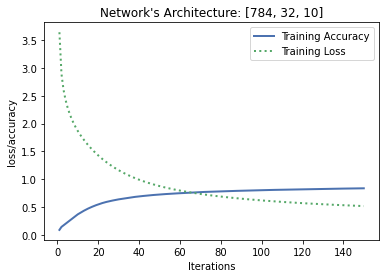

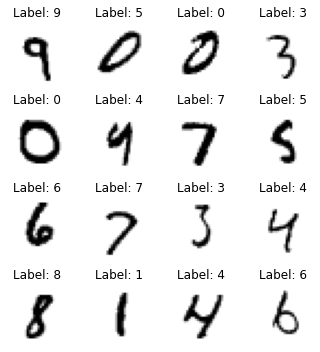

In [221]:
trained_params = gradient_descent(X_train, y_train, layer_architecture[3], iterations, learning_rate)
test_acc = test_accuracy(X_val, y_val, trained_params)
print(f'model test accuracy: {test_acc}')